# Test vectorization, rasterization tools

In [1]:
import vectorization_tools, rasterization_tools
from keras.layers import Input
import numpy as np
# from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline
import ModelA
import h5py
#from config import #DATASET

from utils import load_gray_data
from predictor import Predictor

img_rows, img_cols = 32, 32
img_chn = 3

2024-07-26 18:21:06.886925: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 18:21:06.965872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 18:21:08.010360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-26 18:21:09.832424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

SVHN Grayscale Model1 loaded
Loaded model from disk


2024-07-26 18:21:12.742623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906


1/1 [==============================] - 2s 2s/step
[[8.5325720e-09 2.7335960e-01 1.6350326e-03 7.8127504e-11 2.3768649e-09
  2.9041747e-09 6.2786104e-10 2.9790070e-04 8.7465713e-05 7.2461998e-01]]
(9, 0.4512604)
1/1 [==============================] - 0s 35ms/step


2024-07-26 18:21:13.128562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[[1.3290753e-04 2.3544727e-01 8.1434302e-02 6.6172326e-01 1.3760813e-03
  1.9793008e-03 1.7267112e-02 5.3546828e-04 4.8883692e-05 5.5405213e-05]]
(3, -0.6616678)


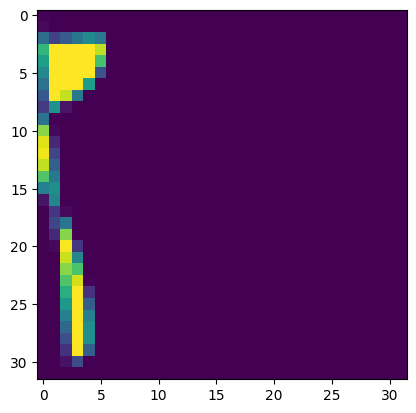

In [2]:
image_generated_temp = np.load("runs/run_1721924295/archive/mbr2160.npy")
plt.imshow(np.reshape(image_generated_temp,(img_rows, img_cols )))
print(Predictor.model.predict(image_generated_temp))
print(Predictor.predict_single(image_generated_temp , 9))

image_generated_temp2 = np.load("runs/run_1721923141/archive/mbr287.npy")
plt.imshow(np.reshape(image_generated_temp2,(img_rows, img_cols )))
print(Predictor.model.predict(image_generated_temp2))
print(Predictor.predict_single(image_generated_temp2 , 9))

In [3]:
confidence_100 = True
explabel = 0

def plot_original_and_rasterized(confidence_100, explabel):
    x_test, y_test = load_gray_data(confidence_100, explabel)

    fig, axs = plt.subplots((len(y_test)+4)//5*2,5)
    fig.tight_layout()
    predict_ori = Predictor.predict(x_test, y_test)
    # print(predict_ori)

    label_presevation_num = 0
    for i, img in enumerate(x_test):
        r = i//5 *2
        c = i-i//5*5
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)

        label_rasterized = Predictor.predict_single(rasterized , explabel)[0]
        if label_rasterized == explabel:
            label_presevation_num += 1
        axs[r, c].imshow(np.reshape(img,(img_rows, img_cols) ))
        axs[r+1, c].imshow(np.reshape(rasterized,(img_rows, img_cols) ))
        axs[r, c].set_title(f"Original {predict_ori[0][i]}, {predict_ori[1][i]}")
        axs[r+1, c].set_title(f"rasterized {Predictor.predict_single(rasterized , explabel)[0]}")

    return label_presevation_num

label preservation rate is 0.98


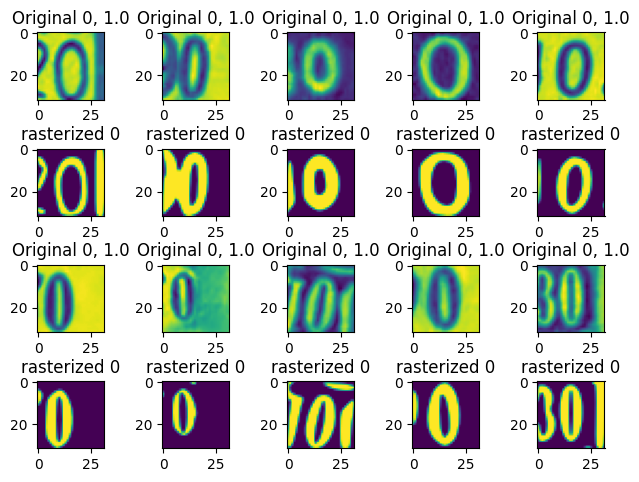

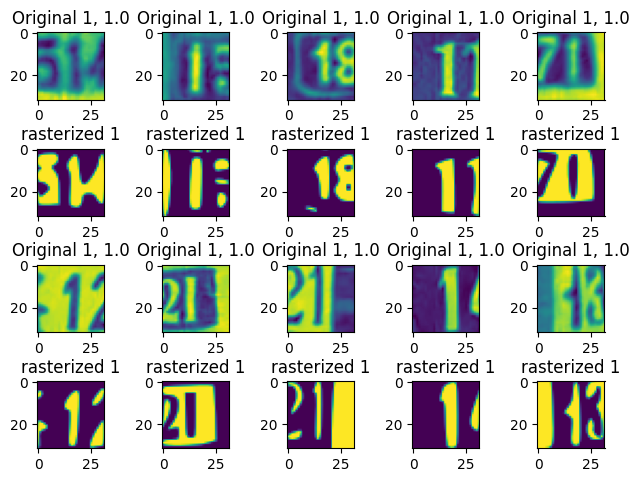

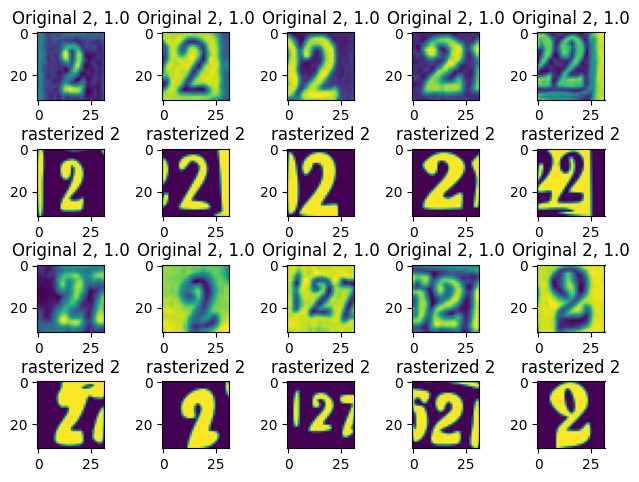

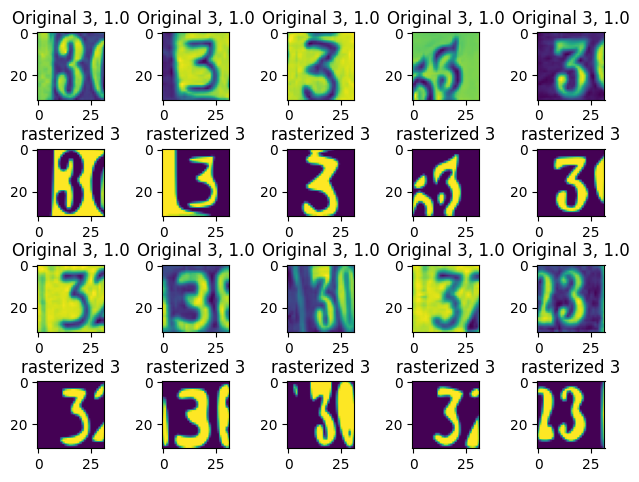

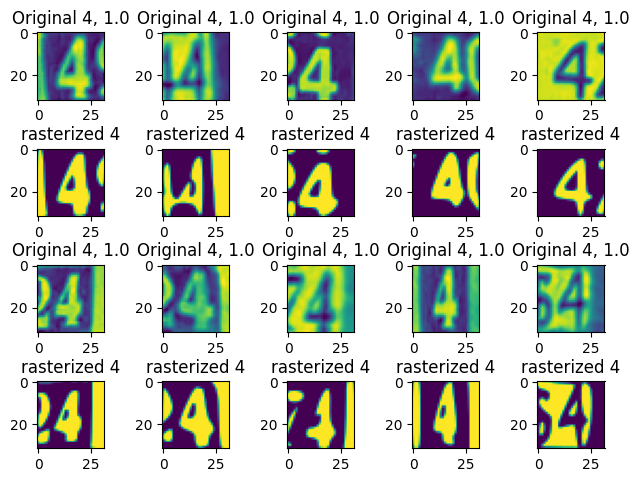

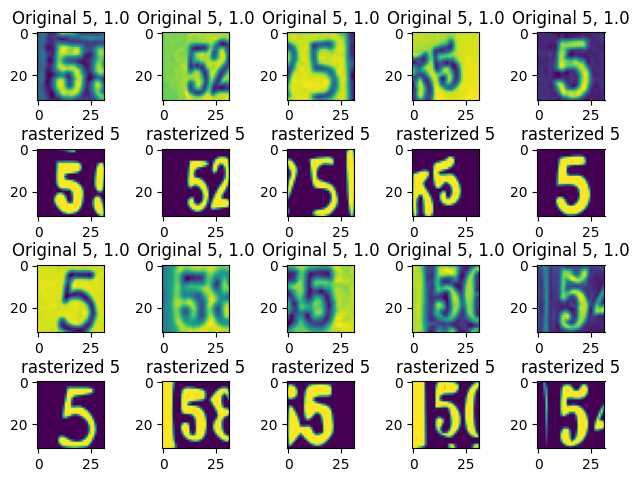

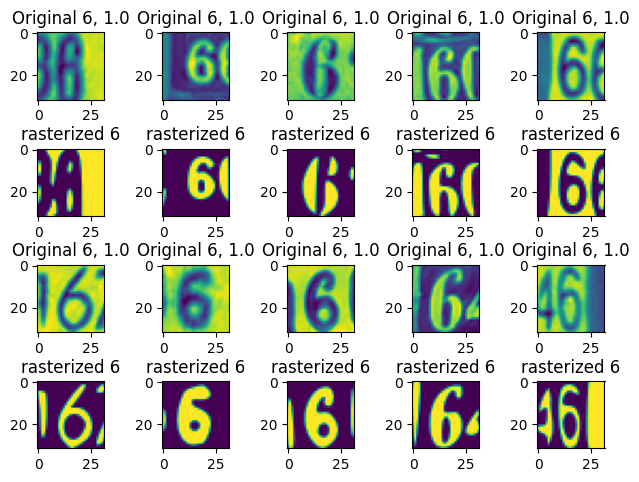

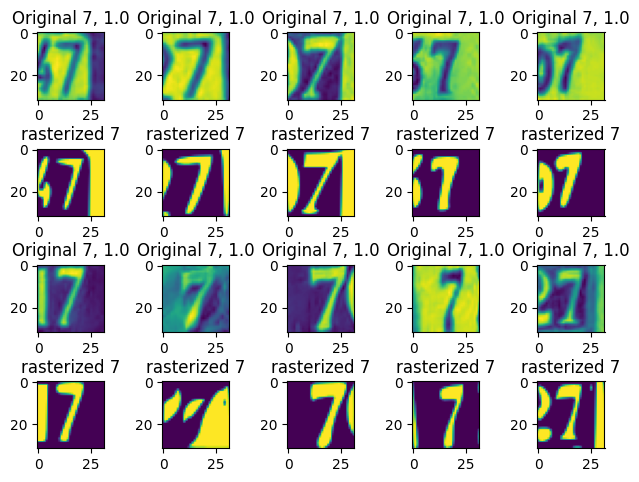

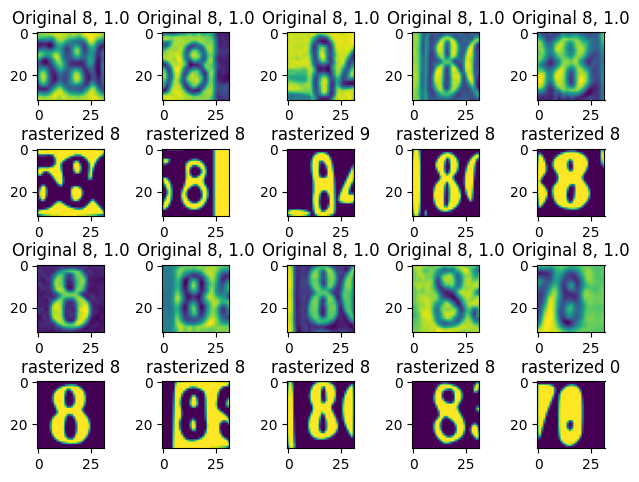

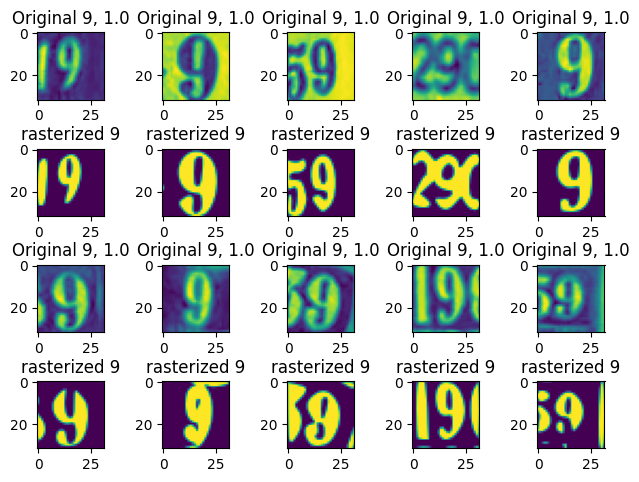

In [4]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized(True, i)

print(f"label preservation rate is {label_presevation_num/100}")

label preservation rate is 0.46


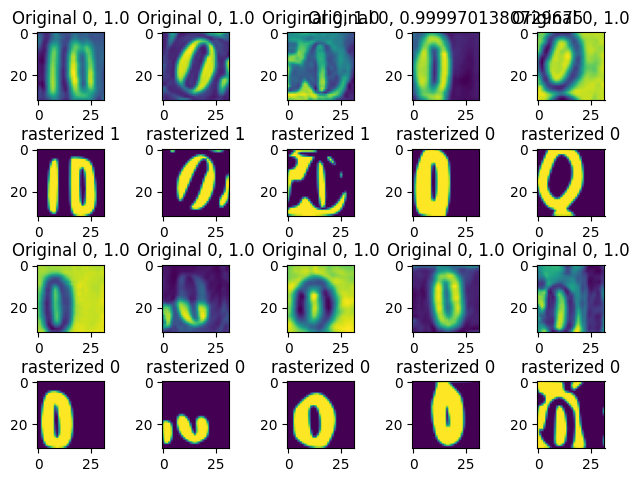

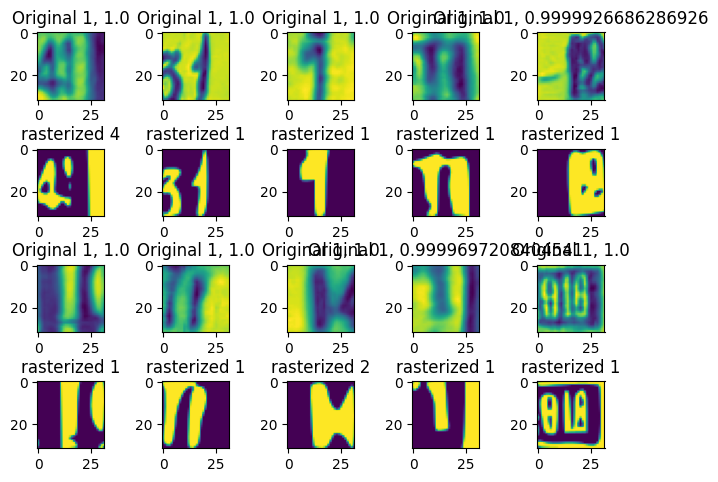

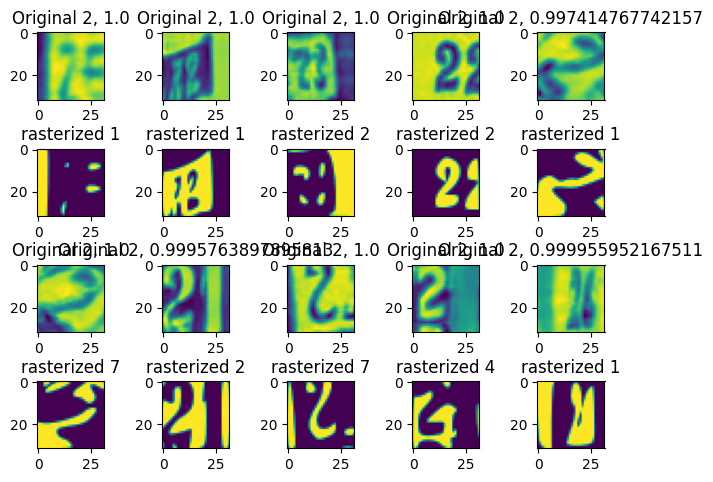

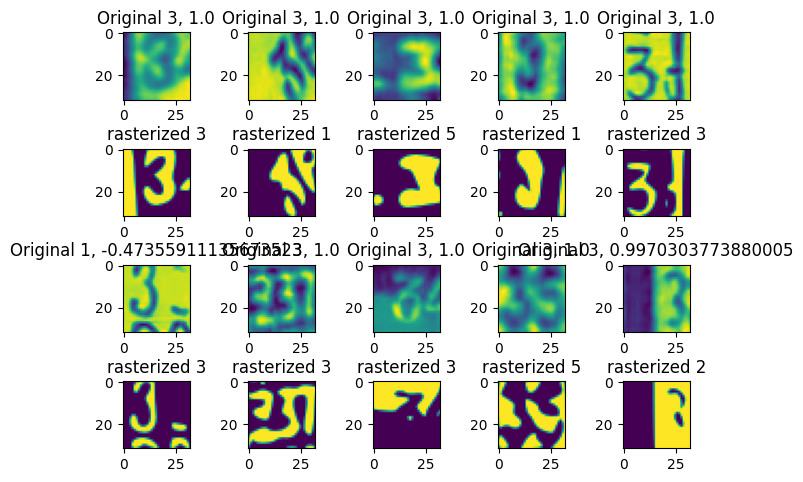

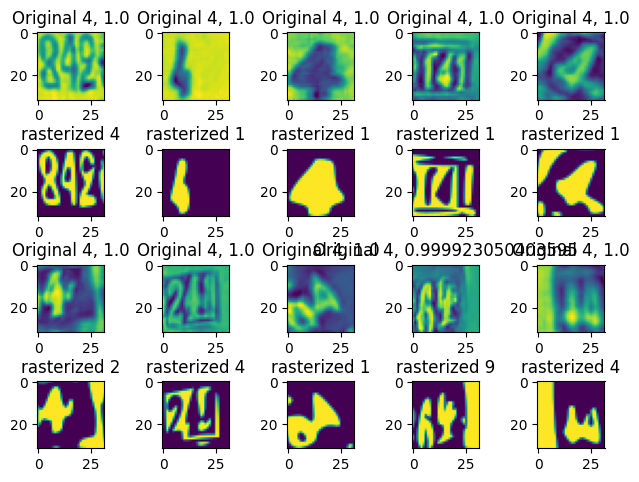

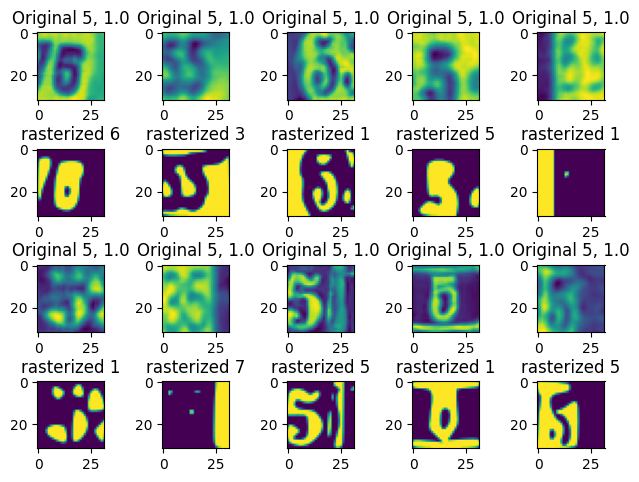

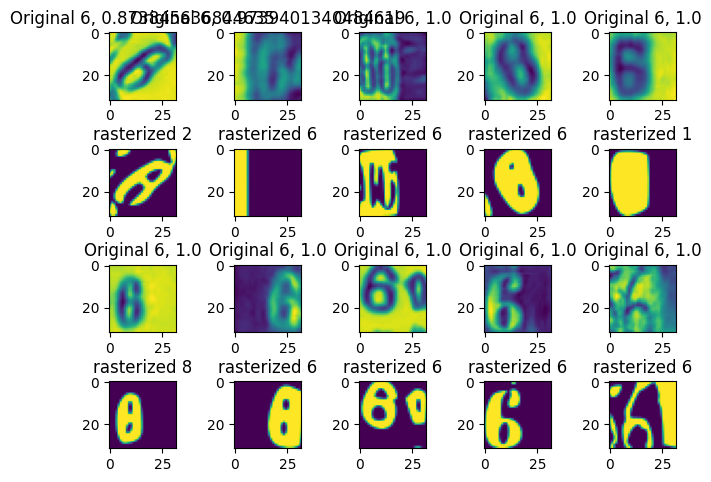

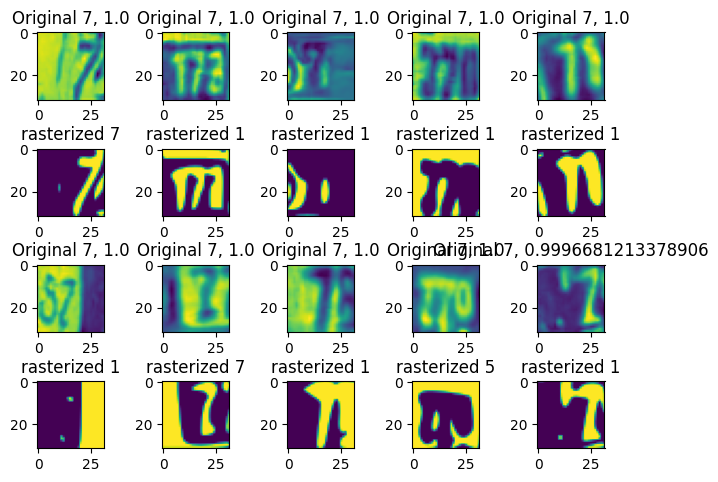

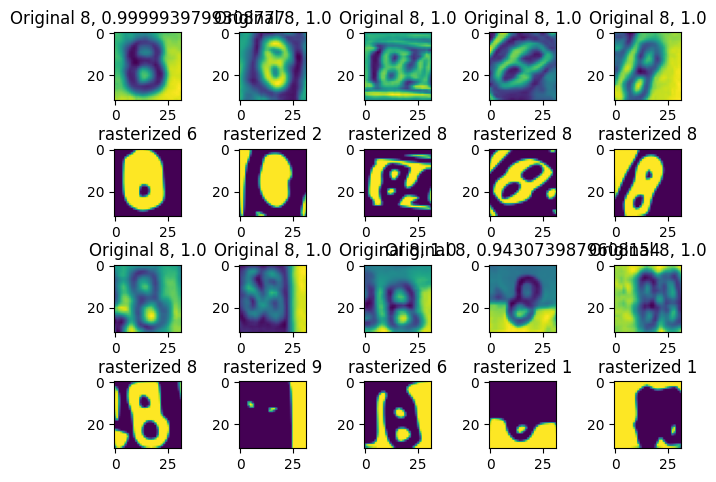

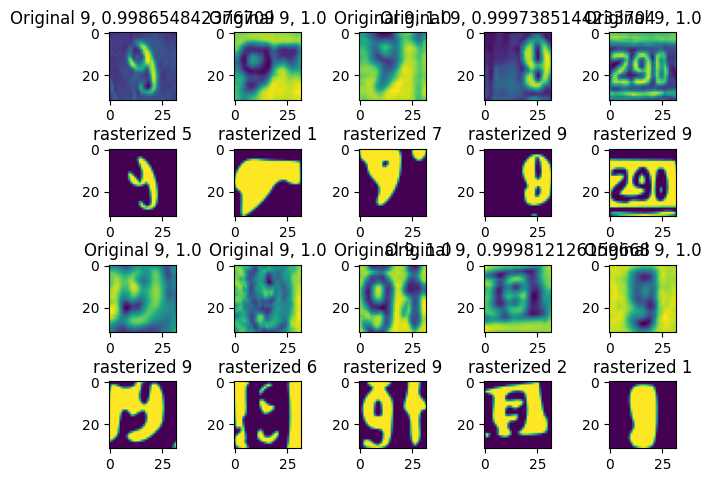

In [5]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized(False, i)

print(f"label preservation rate is {label_presevation_num/100}")

In [15]:
def check_label(x_test, y_test, explabel):
    predictions, _ = (Predictor.predict(img=x_test, label=y_test))
    predictions = np.array(predictions)
    
    # drop labels that are not EXPLABEL
    data_size = x_test.shape[0]
    
    x_test = x_test[predictions == explabel]
    y_test = y_test[predictions == explabel]
    
    if data_size != x_test.shape[0]:
        print("Dropped {} images with wrong label".format(data_size - x_test.shape[0]))
    data_size = x_test.shape[0]
    assert data_size!=0, "No data left"
    
    # drop labels that are not EXPLABEL after rasterization
    new_predictions = []
    for img in x_test:
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)
        prediction_rasterized, _ = Predictor.predict_single(rasterized, explabel)
        new_predictions.append(prediction_rasterized)

    new_predictions = np.array(new_predictions)
    x_test = x_test[np.where(new_predictions == explabel)]
    y_test = y_test[np.where(new_predictions == explabel)]
    if data_size != x_test.shape[0]:
        print("Dropped {} images after rasterization".format(data_size - x_test.shape[0]))
    assert x_test.shape[0]!=0, "No data left"
    
    return x_test, y_test
    

def plot_original_and_rasterized_after_drop(confidence_100, explabel):
    x_test, y_test = load_gray_data(confidence_100, explabel)
    x_test, y_test = check_label(x_test, y_test, explabel)

    if len(y_test) == 0:
        print(f"Nothing left in label {explabel}")
        return 0

    fig, axs = plt.subplots((len(y_test)+4)//5*2,5)
    fig.tight_layout()
    predict_ori = Predictor.predict(x_test, y_test)
    

    label_presevation_num = 0
    for i, img in enumerate(x_test):
        r = i//5 *2
        c = i-i//5*5
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)

        label_rasterized = Predictor.predict_single(rasterized , explabel)[0]
        if label_rasterized == explabel:
            label_presevation_num += 1
        axs[r, c].imshow(np.reshape(img,(img_rows, img_cols) ))
        axs[r+1, c].imshow(np.reshape(rasterized,(img_rows, img_cols) ))
        axs[r, c].set_title(f"Original {predict_ori[0][i]}, {predict_ori[1][i]}")
        axs[r+1, c].set_title(f"rasterized {Predictor.predict_single(rasterized , explabel)[0]}")

    return label_presevation_num

In [7]:
x_test, y_test = load_gray_data(False, 0)
x_test, y_test = check_label(x_test, y_test, explabel)
print(len(y_test))

10 7
Dropped 3 images after rasterization
7


In [8]:
(7+4)//5*2

4

10 7
Dropped 3 images after rasterization


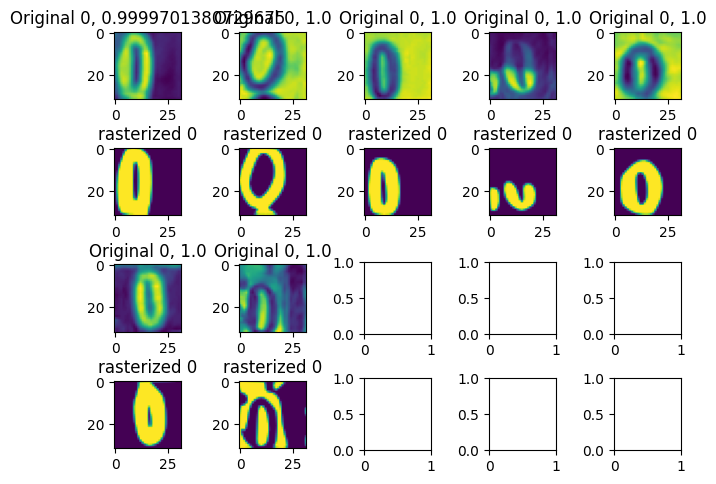

In [13]:
label_presevation_num = plot_original_and_rasterized_after_drop(False, 0)

Dropped 3 images after rasterization
Dropped 2 images after rasterization
Dropped 7 images after rasterization
Dropped 1 images with wrong label
Dropped 5 images after rasterization
Dropped 7 images after rasterization
Dropped 7 images after rasterization
Dropped 3 images after rasterization
Dropped 8 images after rasterization
Dropped 6 images after rasterization
Dropped 6 images after rasterization
label preservation rate is 0.45


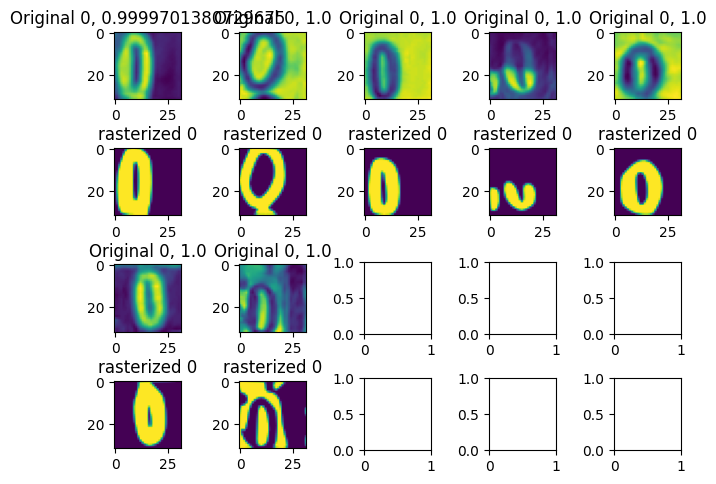

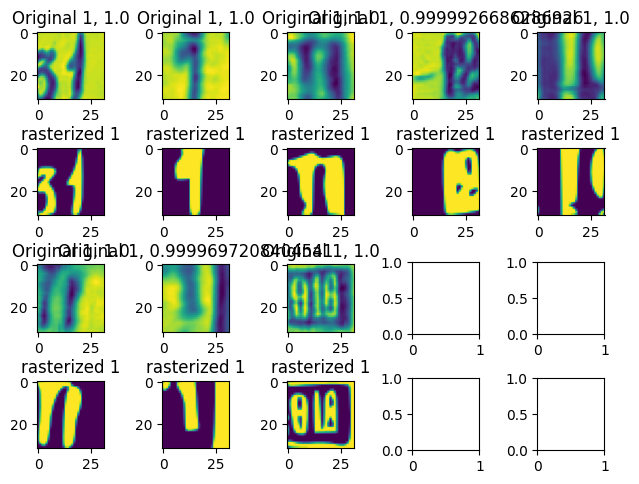

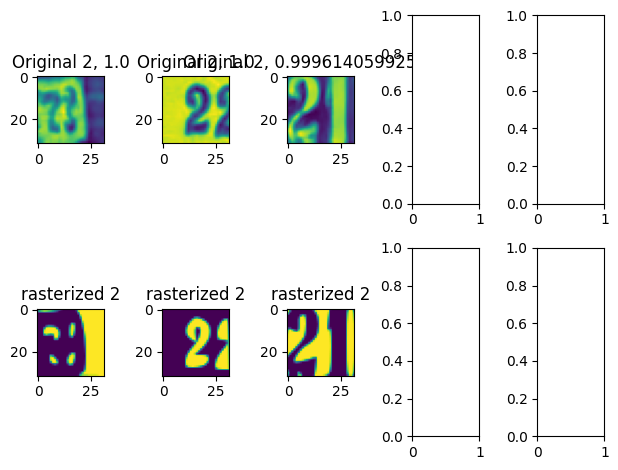

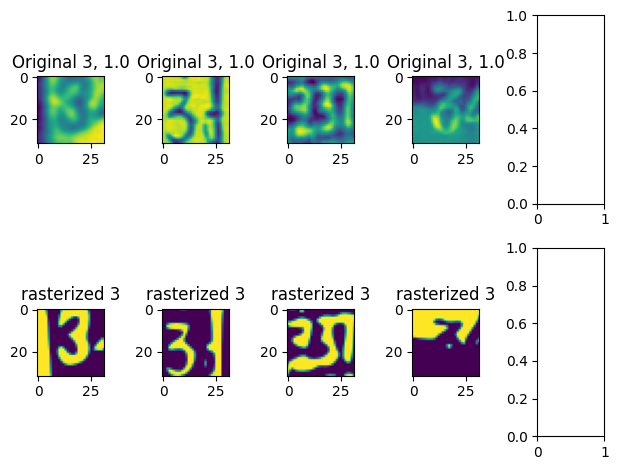

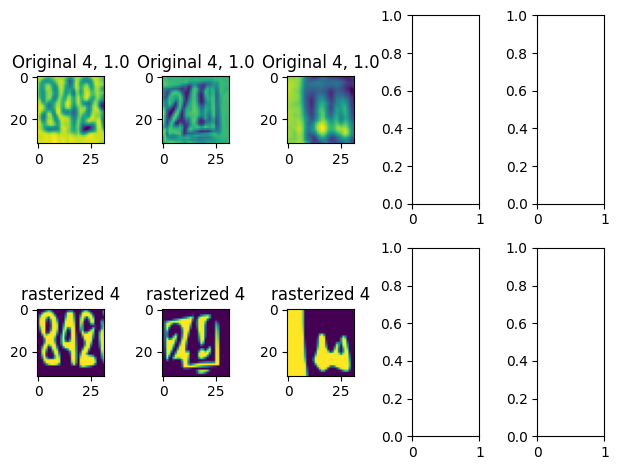

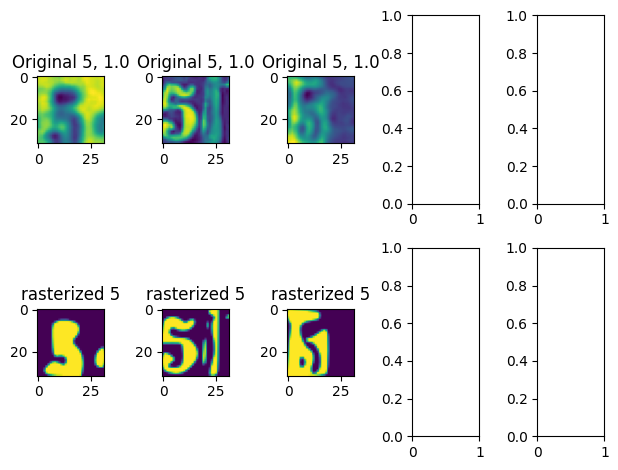

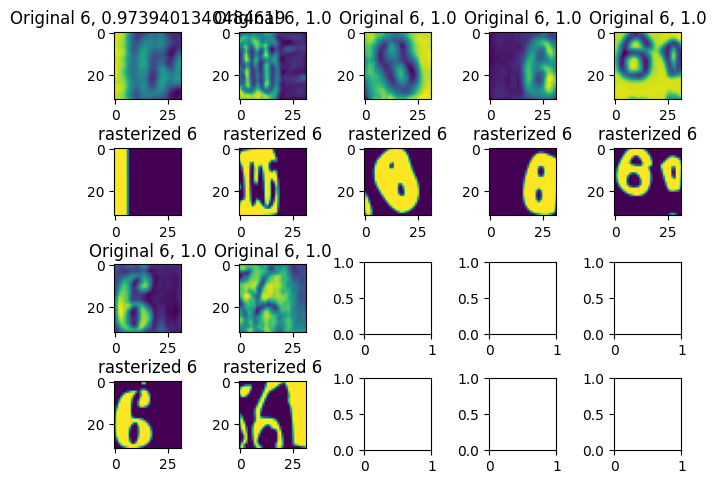

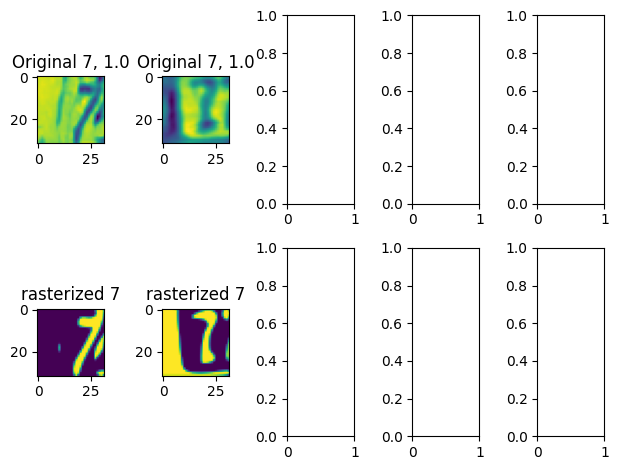

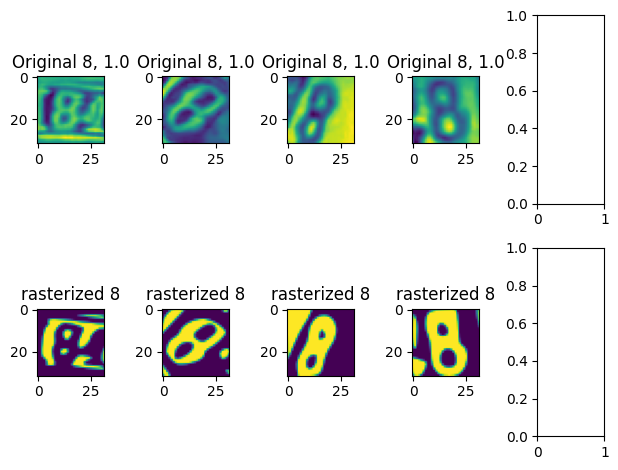

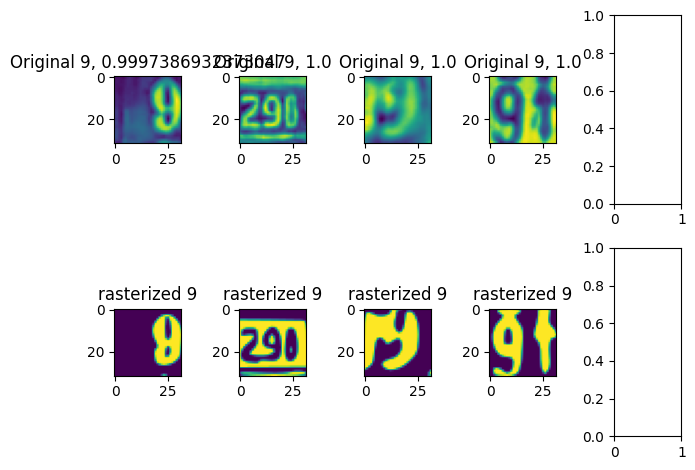

In [16]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized_after_drop(False, i)

print(f"label preservation rate is {label_presevation_num/100}")